# Shiryaev-Roberts experiments for the retraining note (artifical data)

## Shiryaev-Roberts plot

Let us now try SR.
The following code runs about 20 secs for each trajectory for $N=10^6$.

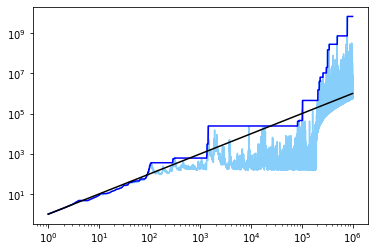

21.878786087036133


In [2]:
import numpy as np

# The key parameters: the 3 below plus Ncal (line 15)
rg = np.random.default_rng(0)     # key parameter; setting the seed for reproducibility [default 0]
Jrate = 0.01  # the jumping rate; in the book: 0.001; canonical: 0.01
K = 1          # the number of trajectories to draw
N = 10**6     # for the plots in the paper
reset_interval = np.inf  # occasional reset to avoid undeflow; default 10,000 (or np.inf)

import matplotlib.pyplot as plt
import time
start = time.time()

# The linear calibrator:
def lin_cal(p,a):
  return 1 + a*(p-0.5)

# My family of calibrators:
Ncal = 3  # the number of calibrators; default 3
def my_cal(p,k):
  if k==0:
    return lin_cal(p,1)
  if k==1:
    return lin_cal(p,-1)
  if k==2:
    return lin_cal(p,0)
  else:
    print("my_cal failure")

my_colors = ['b','r','g','lightskyblue','salmon','greenyellow']

MartCap = np.empty((Ncal,N+1)) # the total capital of martingales in each state
Capital = np.empty(N+1)        # the martingale
SR = np.empty(N+1)     # the SR statistics (whole trajectory)
record_SR = np.empty(N+1) # the records of the SR statistics
for k in range(K):   # going over the trajectories
  MartCap[:,0] = 1/Ncal       # the uniform initial distribution
  SR[0] = 0      # initial SR value
  record_SR[0] = 0  # initial record of SR
  Capital[0] = np.sum(MartCap[:,0]) # the total capital (1)
  # generating the dataset:
  p = rg.random(N)
  for n in range(1,N+1):  # going through the observations
    # Jump mixing starts
    MartCap[:,n] = (1-Jrate)*MartCap[:,n-1] + (Jrate/Ncal)*Capital[n-1]
    # Jump mixing ends
    for kk in range(Ncal):
      MartCap[kk,n] = MartCap[kk,n] * my_cal(p[n-1],kk)
    Capital[n] = np.sum(MartCap[:,n]) # the total capital
    SR[n] = (1+SR[n-1]) * Capital[n] / Capital[n-1]
    if SR[n] > record_SR[n-1]:  # if a new record is set
      record_SR[n] = SR[n]
    else:
      record_SR[n] = record_SR[n-1]
    # to avoid underflow:
    if (n+1)%reset_interval == 0:
      MartCap[:,n] = MartCap[:,n] / Capital[n]
      Capital[n] = 1
  # drawing the SR statistic:
  plt.plot(np.arange(1,N+1),SR[1:(N+1)],c=my_colors[k+3])  # drawing the actual SR statistic
  plt.plot(np.arange(1,N+1),record_SR[1:(N+1)],c=my_colors[k])  # drawing its records

plt.plot(np.arange(1,N+1),np.arange(1,N+1),c='k')
## For plotting the picture with underflow:
# breakpoint_x = 188000 # the visual breakpoint (x-coordinate)
# breakpoint_y = 150    # the visual breakpoint (y-coordinate)
# plt.plot(np.arange(breakpoint_x+1,N+1),np.arange(breakpoint_y+1,N-breakpoint_x+breakpoint_y+1),'k--')
plt.xscale("log")
plt.yscale("log")
plt.savefig("K="+str(int(K))+"_SR_plot.pdf", bbox_inches='tight')
plt.show()

end = time.time()
print(end - start)
import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

In [4]:
Capital[220000:220010]

array([1.        , 1.09168409, 1.23378735, 1.25313991, 1.01065199,
       0.98954656, 0.9111852 , 0.95598209, 0.97289735, 0.94786836])

In [10]:
MartCap[:,270000:270010]

array([[0.12431657, 0.113399  , 0.1149258 , 0.10966964, 0.09348933,
        0.04875922, 0.04428142, 0.02601562, 0.03588252, 0.02412696],
       [0.11215725, 0.12613803, 0.12894719, 0.13930498, 0.16448856,
        0.24788845, 0.28473011, 0.414207  , 0.32732831, 0.45356535],
       [0.76352617, 0.75922425, 0.75496121, 0.75074104, 0.74656602,
        0.74244884, 0.738488  , 0.73466146, 0.73123112, 0.72756695]])

In [8]:
np.nextafter(0,1)

5e-324

A more precise result would be:

* np.nextafter(0,1)
* 4.9406564584124654e-324

In [10]:
np.log2(4.9406564584124654e-324)

-1074.0

In [12]:
np.log2(4.9406564584124654)-324*np.log2(10)

-1074.0

The IEEE 754 standard specifies a binary64 as having:

* Sign bit: 1 bit
* Exponent: 11 bits
* Significand precision: 53 bits (52 explicitly stored)

Exponents range from −1022 to +1023 because exponents of −1023 (all 0s) and +1024 (all 1s) are reserved for special numbers.

We get -1074 as -1022-52.

## CUSUM plot

Just for my interest, let me do a similar plot for CUSUM.
The following code runs also about 20 secs for each trajectory for $N=10^6$.

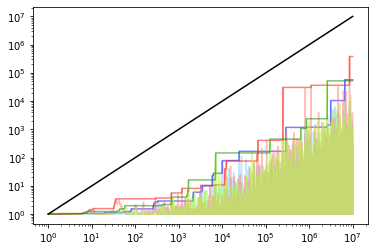

574.0125102996826


In [3]:
import numpy as np

# The key parameters: the 3 below plus Ncal (line 15)
rg = np.random.default_rng(1)     # key parameter; setting the seed for reproducibility [default 0]
Jrate = 0.01  # the jumping rate; in the book: 0.001; canonical: 0.01
K = 3          # the number of trajectories to draw
# N = 6000    # the number of observations for plot 1 (6000)
# N = 25*10**4      # the number of observations for the extra plot
N = 10**7     # for plot 2
reset_interval = 10000  # occasional reset to avoid undeflow

import matplotlib.pyplot as plt
import time
start = time.time()

# The linear calibrator:
def lin_cal(p,a):
  return 1 + a*(p-0.5)

# My family of calibrators:
Ncal = 3  # the number of calibrators; default 3
def my_cal(p,k):
  if k==0:
    return lin_cal(p,1)
  if k==1:
    return lin_cal(p,-1)
  if k==2:
    return lin_cal(p,0)
  else:
    print("my_cal failure")

my_colors = ['b','r','g','lightskyblue','salmon','greenyellow']

MartCap = np.empty((Ncal,N+1)) # the total capital of martingales in each state
Capital = np.empty(N+1)        # the martingale
min_Capital = np.empty(N+1)    # the minimal value of the martingale
CUSUM = np.empty(N+1)     # the CUSUM statistics (whole trajectory)
record_CUSUM = np.empty(N+1) # the records of the SR statistics
for k in range(K):   # going over the trajectories
  MartCap[:,0] = 1/Ncal       # the uniform initial distribution
  CUSUM[0] = 1      # initial CUSUM value
  record_CUSUM[0] = 1  # initial record 
  Capital[0] = np.sum(MartCap[:,0]) # the total capital (1)
  min_Capital[0] = Capital[0]       # the minimal capital (1)
  # generating the dataset:
  p = rg.random(N)
  for n in range(1,N+1):  # going through the observations
    # Jump mixing starts
    MartCap[:,n] = (1-Jrate)*MartCap[:,n-1] + (Jrate/Ncal)*Capital[n-1]
    # Jump mixing ends
    for kk in range(Ncal):
      MartCap[kk,n] = MartCap[kk,n] * my_cal(p[n-1],kk)
    Capital[n] = np.sum(MartCap[:,n]) # the total capital
    if Capital[n] < min_Capital[n-1]:  # if a new record is set
      min_Capital[n] = Capital[n]
    else:
      min_Capital[n] = min_Capital[n-1]
    CUSUM[n] = Capital[n] / min_Capital[n]
    if CUSUM[n] > record_CUSUM[n-1]:  # if a new record is set
      record_CUSUM[n] = CUSUM[n]
    else:
      record_CUSUM[n] = record_CUSUM[n-1]
    # to avoid underflow:
    if n%reset_interval == 0:
      MartCap[:,n] = MartCap[:,n] / min_Capital[n]
      Capital[n] = Capital[n] / min_Capital[n]
      min_Capital[n] = 1
  # drawing the SR statistic:
  plt.plot(np.arange(1,N+1),CUSUM[1:(N+1)],c=my_colors[k+3],alpha=0.5)  # drawing the actual CUSUM statistic
  plt.plot(np.arange(1,N+1),record_CUSUM[1:(N+1)],c=my_colors[k],alpha=0.5)  # drawing its records

plt.plot(np.arange(1,N+1),np.arange(1,N+1),c='k')
plt.xscale("log")
plt.yscale("log")
plt.show()

end = time.time()
print(end - start)
import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

## Sandpit

In [6]:
import numpy as np
A = np.linspace(0,0.5,11)
print(A)
print(A.size)

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]
11


In [7]:
B = np.linspace(0,0.5,11)
C = A+B
print(C)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [37]:
small = 2.96e-323

In [41]:
small/10

5e-324